<a href="https://colab.research.google.com/github/carloshvp/salary-predictor/blob/main/salary_predictor_Spain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Salary Predictor for Spain

This notebook is meant to create a Machine Learning model which is able to predict the net salary in Spain based on certain parameters. For this purpose, we are using the Dataset from the Spanish National Statistics Institute (Instituto Nacional de Estadística) about salaries, based on a survey on 220 thousand employees in 2018. This study is harmonized through [EuroStat](https://ec.europa.eu/eurostat/web/microdata/labour-force-survey) with similar surveys from each of the EU countries. For this reason, it would be a relatively easy task to do a similar analysis with other countries of the EU. The methodology of the survey, raw datasets and many other additional information can be found in [this link](https://www.ine.es/dyngs/INEbase/es/operacion.htm?c=Estadistica_C&cid=1254736177025&menu=resultados&idp=1254735976596#!tabs-1254736195110).



## Exploratory Data Analysis
In the first part of this Notebook we are going to load the Dataset and get a feeling about the contained data. We will analyze the data and perform the required operations of cleaning and preparation for the next step, where we will train several Machine Learning models to predict the salary according to selected features.

If the reader of this Notebook can also read Spanish, we would recommend to go through [this document](https://www.ine.es/prensa/eces_2018_d.pdf), which is the official press-release with the analysis of the survey by the Spanish National Statistics Institute (INE).

In [ ]:
!pip install scikit-learn --upgrade
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import sklearn

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.7/dist-packages (0.24.2)


In [ ]:
# Mounting Google Drive to load Dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# We load the dataset as a Pandas Dataframe
df = pd.read_csv("/content/drive/My Drive/Salary Predictor/EES_2018.csv",sep="\t")
df.head()

,IDENCCC,ORDENTRA,NUTS1,CNACE,ESTRATO2,CONTROL,MERCADO,REGULACION,SEXO,TIPOPAIS,CNO1,RESPONSA,ESTU,ANOANTI,MESANTI,TIPOJOR,TIPOCON,FIJODISM,FIJODISD,VAL,VAN,PUENTES,JAP,JSP1,JSP2,HEXTRA,DRELABM,SIESPM1,DSIESPM1,SIESPM2,DSIESPM2,SALBASE,EXTRAORM,PHEXTRA,COMSAL,COMSALTT,IRPFMES,COTIZA,BASE,DRELABAM,DRELABAD,SIESPA1,DSIESPA1,SIESPA2,DSIESPA2,SIESPA3,DSIESPA3,SIESPA4,DSIESPA4,RETRINOIN,RETRIIN,GEXTRA,VESPNOIN,VESPIN,ANOS2,FACTOTAL
0,25,1,1,H1,1,2,3,2,1,1,N0,0,3,28,10,2,2,0,0,0,31,0,898,20,0,0,31,6,0,6,0,332.09,0.0,0.0,89.7,0.0,45.22,74.63,1175.30,12,0,6,0,6,0,6,0,6,0,6128.65,0.0,787.35,0.0,0.0,6,70.48
1,25,2,1,H1,1,2,3,2,1,1,N0,0,3,10,2,1,1,0,0,0,31,0,1796,40,0,0,31,6,0,6,0,1328.33,0.0,0.0,40.0,0.0,100.85,86.89,1368.33,12,0,6,0,6,0,6,0,6,0,16509.97,0.0,3127.50,0.0,0.0,6,70.48
2,25,3,1,H1,1,2,3,2,6,1,C0,0,7,4,1,1,1,0,0,0,31,0,1796,40,0,0,31,6,0,6,0,1333.70,0.0,0.0,190.0,0.0,113.21,96.75,1523.71,12,0,6,0,6,0,6,0,6,0,18284.40,0.0,3200.76,0.0,0.0,4,70.48
3,25,4,1,H1,1,2,3,2,1,1,N0,0,3,14,11,1,1,0,0,0,31,0,1796,40,0,0,31,6,0,6,0,1328.33,0.0,0.0,40.0,0.0,71.56,86.89,1368.33,12,0,6,0,6,0,6,0,6,0,16549.97,0.0,3127.77,0.0,0.0,6,70.48
4,25,5,1,H1,1,2,3,2,1,1,N0,0,3,6,4,1,1,0,0,0,31,0,1796,40,0,0,31,6,0,6,0,1319.78,0.0,0.0,40.0,0.0,121.29,86.35,1359.78,12,0,6,0,6,0,6,0,6,0,16554.71,0.0,3072.51,0.0,0.0,4,70.48


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216726 entries, 0 to 216725
Data columns (total 56 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   IDENCCC     216726 non-null  int64  
 1   ORDENTRA    216726 non-null  int64  
 2   NUTS1       216726 non-null  int64  
 3   CNACE       216726 non-null  object 
 4   ESTRATO2    216726 non-null  int64  
 5   CONTROL     216726 non-null  int64  
 6   MERCADO     216726 non-null  int64  
 7   REGULACION  216726 non-null  int64  
 8   SEXO        216726 non-null  int64  
 9   TIPOPAIS    216726 non-null  int64  
 10  CNO1        216726 non-null  object 
 11  RESPONSA    216726 non-null  int64  
 12  ESTU        216726 non-null  int64  
 13  ANOANTI     216726 non-null  int64  
 14  MESANTI     216726 non-null  int64  
 15  TIPOJOR     216726 non-null  int64  
 16  TIPOCON     216726 non-null  int64  
 17  FIJODISM    216726 non-null  int64  
 18  FIJODISD    216726 non-null  int64  
 19  VA

# Feature selection
As we can see, the dataset has 56 features and 216726 entries. There is apparently no missing data. There are however several columns which we believe have no significant impact in the salary reported. This is, for example, identifiers between others. In the next list we can see the columns we consider most relevant and are therefore going to use in the next steps. Note that we have translated into English to the best of our knowledge and might be partially inaccurate or subjectively biased

* **NUTS1: Region/zone in Spain**
 * 1: North-west
 * 2: North-east
 * 3: Madrid region
 * 4: Central
 * 5: East
 * 6: South
 * 7: Canary islands
* **CNACE: Activity code**
 * B0: Extractive industries (oil, coal, anthracite, etc.)
 * C1: Manufacturing industry. Food and drinks
 * C2: ...
* **CONTROL: Company ownership**
 * 1: Public
 * 2: Private
* **MERCADO: Target market**
 * 1: Local/regional
 * 2: National
 * 3: European Union
 * 4: World-wide
* **REGULACION: Workers contract agreement type**
 * 1: Sectorial national labor union agreement
 * 2: Sectorial regional labor union agreement
 * 3: Company/business group agreement
 * 4: Workplace agreement
 * 5: Others
* **SEXO: Employee's genre**
 * 1: Male
 * 6: Female
* **TIPOPAIS: Employee's nationality**
 * 1: Spanish
 * 2: Others
* **CNO1: Type of occupation**
 * A0: Directors and general managers
 * B0: Technical or scientific professionals in health or education
 * C0: Other technical or scientific professionals
 * D0: Technical or professional assistants
 * E0: Administrative employees without public facing relations
 * F0: Administrative employees with public facing relations
 * G0: Workers in catering, restaurants and commerce
 * H0: Workers in health and people care
 * I0: Workers in protection and security services
 * J0: Qualified workers in agriculture, forestal and fishing sector
 * K0: Qualified workers in contruction, excluding machine operators
 * L0: Qualified workers in manufacturing, excluding plant and machine operations
 * M0: Plant and machine operators
 * N0: Drivers and operators of mobile machinery
 * O0: Non-qualified workers in services sector
 * P0: Non-qualified Workers in agriculture, fishing, construction, manufacturing and transportation sectors
 * Q0: Military occupations
* **RESPONSA: Supervision and organizational responsibilities**
 * 0: No
 * 1: Yes
* **ESTU: Level of studies completed**
 * 1: Less than primary school
 * 2: Primary school
 * 3: First phase of secondary education
 * 4: Second phase of secondary education
 * 5: Vocational training
 * 6: University Bachelor degree
 * 7: University Masters or PhD degree
* **ANOANTI: Years of experience**
* MESANTI: Months of experience. We are not using the number of months of experience, since this is just providing further granularity to the amount of years of experience (previous feature)
* **TIPOJOR: Type of job**
 * 1: Full-time
 * 2: Part-time
* **TIPOCON: Contract duration**
 * 1: Undefined
 * 2: Temporal
* **RETRINOIN: Yearly net salary.** Note this excludes salaries for partially disabled employees

We will therefore drop all other columns in the next cells.


In [ ]:
# We select now the columns of our interest
df1 = df[['NUTS1', 'CNACE', 'ESTRATO2', 'CONTROL', 'MERCADO', 'REGULACION' , 'SEXO', 'TIPOPAIS', 'CNO1', 'RESPONSA', 'ESTU', 'ANOANTI', 'TIPOJOR', 'TIPOCON', 'RETRINOIN']]
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216726 entries, 0 to 216725
Data columns (total 15 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   NUTS1       216726 non-null  int64  
 1   CNACE       216726 non-null  object 
 2   ESTRATO2    216726 non-null  int64  
 3   CONTROL     216726 non-null  int64  
 4   MERCADO     216726 non-null  int64  
 5   REGULACION  216726 non-null  int64  
 6   SEXO        216726 non-null  int64  
 7   TIPOPAIS    216726 non-null  int64  
 8   CNO1        216726 non-null  object 
 9   RESPONSA    216726 non-null  int64  
 10  ESTU        216726 non-null  int64  
 11  ANOANTI     216726 non-null  int64  
 12  TIPOJOR     216726 non-null  int64  
 13  TIPOCON     216726 non-null  int64  
 14  RETRINOIN   216726 non-null  float64
dtypes: float64(1), int64(12), object(2)
memory usage: 24.8+ MB


# Further cleaning and preparing our dataset
As we have previously shown in the description of the features we are using, there are several additional steps we need to do, so that the dataset is ready to use.

First of all, we are removing the entries where the salary is zero. There might be several reasons why we may see this value, starting by the fact that we have not considered salaries which origin are related to disabilities. Since we are only considering salaries which origin is not related to disabilities, we also remove the entries where the salary due to disabilities is higher than zero. We would however like to recommend other researchers to fill the gap in this study to provide a more inclusive salary predictor in the future.

In the next step, we will one-hot encode the features which do not have an ordinal relationship (categories do not have a logical order). These are: NUTS1, CNACE, REGULACION and CNO1

We will drop all columns which we don't need anymore and finally set the target attribute (salary) as the first column of the dataframe for convenience.

By doing this, we end up with a Dataset with 177731 entries (instead of 216726), 58 columns (instead of 56, though most of them are one-hot encoded)


In [ ]:
# We keep only the entries where the salary is higher than 0 and no additional
#salaries were obtained due to disabilities
df2 = df[(df['RETRINOIN'] > 0) & (df['RETRIIN']  == 0)]
df2.shape

(177731, 56)

In [ ]:
# Re-encoding the features NUTS1, CNACE, REGULACION and CNO1 to one-hot enconding
NUTS1_onehot = pd.get_dummies(df2.NUTS1, prefix='Region')
CNACE_onehot = pd.get_dummies(df2.CNACE, prefix='Economic_code')
REGULACION_onehot = pd.get_dummies(df2.NUTS1, prefix='Agreement_type')
CNO1_onehot = pd.get_dummies(df2.NUTS1, prefix='Ocupation_type')
# We add the created one-hot encoded columns at the end
df3_1 = pd.concat([df2,NUTS1_onehot],axis=1)
df3_2 = pd.concat([df3_1,CNACE_onehot],axis=1)
df3_3 = pd.concat([df3_2,REGULACION_onehot],axis=1)
df3 = pd.concat([df3_3,CNO1_onehot],axis=1)
df3.head()

,IDENCCC,ORDENTRA,NUTS1,CNACE,ESTRATO2,CONTROL,MERCADO,REGULACION,SEXO,TIPOPAIS,CNO1,RESPONSA,ESTU,ANOANTI,MESANTI,TIPOJOR,TIPOCON,FIJODISM,FIJODISD,VAL,VAN,PUENTES,JAP,JSP1,JSP2,HEXTRA,DRELABM,SIESPM1,DSIESPM1,SIESPM2,DSIESPM2,SALBASE,EXTRAORM,PHEXTRA,COMSAL,COMSALTT,IRPFMES,COTIZA,BASE,DRELABAM,...,Economic_code_C1,Economic_code_C2,Economic_code_C3,Economic_code_C4,Economic_code_C5,Economic_code_C6,Economic_code_C7,Economic_code_C8,Economic_code_D0,Economic_code_E0,Economic_code_F0,Economic_code_G1,Economic_code_G2,Economic_code_H1,Economic_code_H2,Economic_code_I0,Economic_code_J0,Economic_code_K0,Economic_code_L0,Economic_code_M0,Economic_code_N0,Economic_code_O0,Economic_code_P0,Economic_code_Q0,Economic_code_R0,Economic_code_S0,Agreement_type_1,Agreement_type_2,Agreement_type_3,Agreement_type_4,Agreement_type_5,Agreement_type_6,Agreement_type_7,Ocupation_type_1,Ocupation_type_2,Ocupation_type_3,Ocupation_type_4,Ocupation_type_5,Ocupation_type_6,Ocupation_type_7
0,25,1,1,H1,1,2,3,2,1,1,N0,0,3,28,10,2,2,0,0,0,31,0,898,20,0,0,31,6,0,6,0,332.09,0.0,0.0,89.7,0.0,45.22,74.63,1175.30,12,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
1,25,2,1,H1,1,2,3,2,1,1,N0,0,3,10,2,1,1,0,0,0,31,0,1796,40,0,0,31,6,0,6,0,1328.33,0.0,0.0,40.0,0.0,100.85,86.89,1368.33,12,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
2,25,3,1,H1,1,2,3,2,6,1,C0,0,7,4,1,1,1,0,0,0,31,0,1796,40,0,0,31,6,0,6,0,1333.70,0.0,0.0,190.0,0.0,113.21,96.75,1523.71,12,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
3,25,4,1,H1,1,2,3,2,1,1,N0,0,3,14,11,1,1,0,0,0,31,0,1796,40,0,0,31,6,0,6,0,1328.33,0.0,0.0,40.0,0.0,71.56,86.89,1368.33,12,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
4,25,5,1,H1,1,2,3,2,1,1,N0,0,3,6,4,1,1,0,0,0,31,0,1796,40,0,0,31,6,0,6,0,1319.78,0.0,0.0,40.0,0.0,121.29,86.35,1359.78,12,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0


In [ ]:
# We now drop all other unnecessary columns
df4=df3.drop(["IDENCCC","ORDENTRA","NUTS1","CNACE","ESTRATO2","REGULACION","CNO1","MESANTI","FIJODISM","FIJODISD","VAL","VAN","PUENTES","JAP","JSP1","JSP2","HEXTRA","DRELABM","SIESPM1","DSIESPM1","SIESPM2","DSIESPM2","SALBASE","EXTRAORM","PHEXTRA","COMSAL","COMSALTT","IRPFMES","COTIZA","BASE","DRELABAM","DRELABAD","SIESPA1","DSIESPA1","SIESPA2","DSIESPA2","SIESPA3","DSIESPA3","SIESPA4","DSIESPA4","RETRIIN","GEXTRA","VESPNOIN","VESPIN","ANOS2","FACTOTAL"], axis=1)
df4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 177731 entries, 0 to 216725
Data columns (total 58 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   CONTROL           177731 non-null  int64  
 1   MERCADO           177731 non-null  int64  
 2   SEXO              177731 non-null  int64  
 3   TIPOPAIS          177731 non-null  int64  
 4   RESPONSA          177731 non-null  int64  
 5   ESTU              177731 non-null  int64  
 6   ANOANTI           177731 non-null  int64  
 7   TIPOJOR           177731 non-null  int64  
 8   TIPOCON           177731 non-null  int64  
 9   RETRINOIN         177731 non-null  float64
 10  Region_1          177731 non-null  uint8  
 11  Region_2          177731 non-null  uint8  
 12  Region_3          177731 non-null  uint8  
 13  Region_4          177731 non-null  uint8  
 14  Region_5          177731 non-null  uint8  
 15  Region_6          177731 non-null  uint8  
 16  Region_7          17

In [ ]:
# We are finally moving the column with the salary to the beginning
salary = df4.RETRINOIN
df5 = df4.drop(['RETRINOIN'], axis=1)
df5.insert(0, 'Salary', salary)
df5.head()

,Salary,CONTROL,MERCADO,SEXO,TIPOPAIS,RESPONSA,ESTU,ANOANTI,TIPOJOR,TIPOCON,Region_1,Region_2,Region_3,Region_4,Region_5,Region_6,Region_7,Economic_code_B0,Economic_code_C1,Economic_code_C2,Economic_code_C3,Economic_code_C4,Economic_code_C5,Economic_code_C6,Economic_code_C7,Economic_code_C8,Economic_code_D0,Economic_code_E0,Economic_code_F0,Economic_code_G1,Economic_code_G2,Economic_code_H1,Economic_code_H2,Economic_code_I0,Economic_code_J0,Economic_code_K0,Economic_code_L0,Economic_code_M0,Economic_code_N0,Economic_code_O0,Economic_code_P0,Economic_code_Q0,Economic_code_R0,Economic_code_S0,Agreement_type_1,Agreement_type_2,Agreement_type_3,Agreement_type_4,Agreement_type_5,Agreement_type_6,Agreement_type_7,Ocupation_type_1,Ocupation_type_2,Ocupation_type_3,Ocupation_type_4,Ocupation_type_5,Ocupation_type_6,Ocupation_type_7
0,6128.65,2,3,1,1,0,3,28,2,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
1,16509.97,2,3,1,1,0,3,10,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
2,18284.40,2,3,6,1,0,7,4,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
3,16549.97,2,3,1,1,0,3,14,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
4,16554.71,2,3,1,1,0,3,6,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0


In [ ]:
# We can get a good feeling of the Salary distribution by running .describe()
# Someone has reported a salary of 4.2 Million €!!
df5.Salary.describe()

count    1.777310e+05
mean     2.710795e+04
std      3.472887e+04
min      6.300000e+01
25%      1.368428e+04
50%      2.160801e+04
75%      3.340240e+04
max      4.225998e+06
Name: Salary, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3257e82490>]],
      dtype=object)

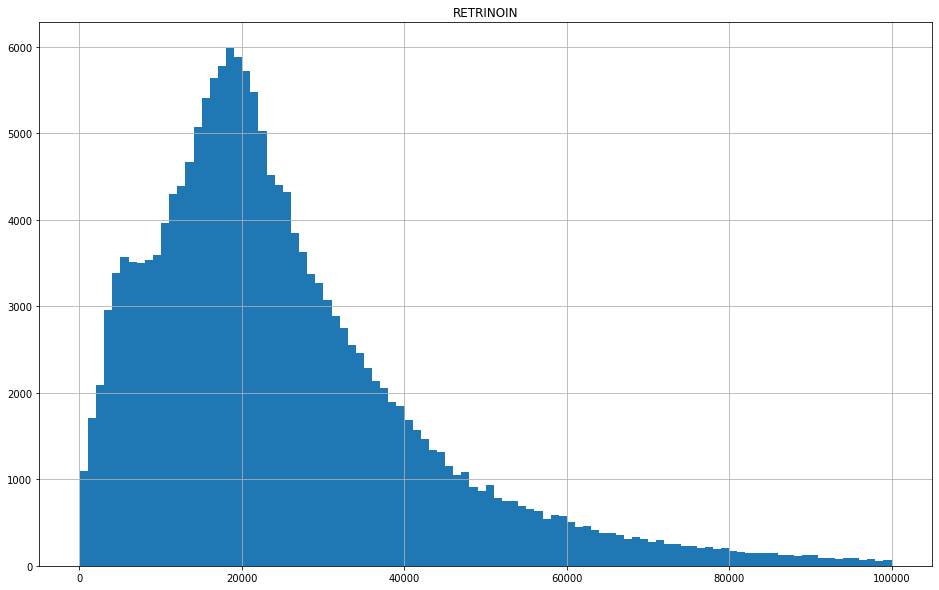

In [ ]:
# We can see here the salary distribution for salaries below 100 thousand Euros
# per year. This is a right-skewed distribution, typical for salary distribution
df4_under100k = df2[df2['RETRINOIN'] < 100000]
df4_under100k.hist(column='RETRINOIN', bins=100,figsize=(16,10), )

In [ ]:
# We can also see that the average salary for a female is below that of a male
avg_male = df5[df5['SEXO'] == 1]['Salary'].mean()
avg_female = df5[df5['SEXO'] == 6]['Salary'].mean()
print(f"The average salary for males is {avg_male}€ while for females only {avg_female}€")

The average salary for males is 30232.12981703658€ while for females only 22810.215291256078€


Text(0, 0.5, 'Average salary (€)')

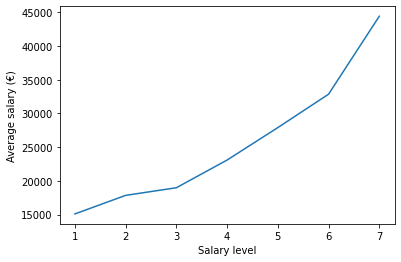

In [ ]:
# We can also see the impact of having higher education in the average salary
salary_by_education = df5.groupby("ESTU")["Salary"].mean()
plt.plot(salary_by_education)
plt.xlabel("Salary level")
plt.ylabel("Average salary (€)")

# Linear regression
In a first approach we are going to run a linear regressor to try to approximate the prediction of the salary. We expect this to work good if the relationships between the different input and output features is linear

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

rs = 1234  # Semilla aleatoria

# We divide the dataset in train and test sub-sets
train_set, test_set = train_test_split(df5, train_size = 0.8, random_state = rs)
X_train = train_set.drop("Salary", axis=1)
y_train = train_set["Salary"]
X_test = test_set.drop("Salary", axis=1)
y_test = test_set["Salary"]

# Training the linear regressor
lr = LinearRegression()

lr.fit(X_train,y_train)

y_pred = lr.predict(X_test)

rmse_lr_train = mean_squared_error(y_train,lr.predict(X_train),squared = False)
rmse_lr_test = mean_squared_error(y_test,y_pred,squared = False)

mae_lr_train = mean_absolute_error(y_train,lr.predict(X_train))
mae_lr_test = mean_absolute_error(y_test,y_pred)

print("Train RMSE:",rmse_lr_train)
print("Test RMSE:",rmse_lr_test)
print("Train MAE:",mae_lr_train)
print("Test MAE:",mae_lr_test)

Train RMSE: 30966.184637983526
Test RMSE: 31071.08918653078
Train MAE: 10382.23429247472
Test MAE: 10469.048475439116


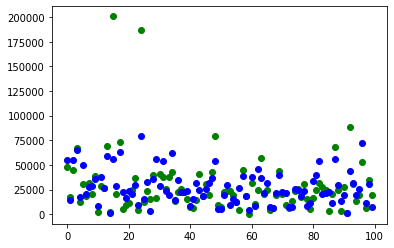

In [ ]:
plt.scatter(range(100),y_test[:100], color = "green")
plt.scatter(range(100),y_pred[:100],color = "blue")

With a Mean Absolute Error higher than 10 thousand € when the average salary is 27 thousand €, we don't believe this is a good predictor. Both train and test sets show a similar error, which makes us think we don't have an overfitting situation, rather a high bias. For this reason, the predictor will not improve by adding regularization.

# K-Nearest Neighbors

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

rmse_train_knn = []
rmse_test_knn = []

ks = range(1,10,1)

for k in ks:

    reg = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsRegressor(n_neighbors=k))])
    reg.fit(X_train,y_train)
    y_pred = reg.predict(X_test)
    rmse_train_knn.append(mean_squared_error(y_train,reg.predict(X_train), squared = False))
    rmse_test_knn.append(mean_squared_error(y_test,y_pred, squared = False))

plt.plot(ks,rmse_train_knn, label = "KNN RMSE train", color = "blue")
plt.plot(ks,rmse_test_knn, label = "KNN RMSE test", color = "green")
plt.legend()

error, k = min(zip(rmse_test_knn,ks))
print("El menor error es", error, "y se alcanza con k =",k)

KeyboardInterrupt: ignored

# Decision Tree regressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor

reg = DecisionTreeRegressor(random_state = rs)
reg.fit(X_train,y_train)
y_pred = reg.predict(X_test)

print("Error en train",mean_squared_error(y_train,reg.predict(X_train), squared = False))
print("Error en test",mean_squared_error(y_test,y_pred, squared = False))

Error en train 13300.02081828109
Error en test 38317.97382041766


# Random Forest regressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor

reg = DecisionTreeRegressor(random_state = rs)
reg.fit(X_train,y_train)
y_pred = reg.predict(X_test)

print("Error en train",mean_squared_error(y_train,reg.predict(X_train), squared = False))
print("Error en test",mean_squared_error(y_test,y_pred, squared = False))

Error en train 13300.02081828109
Error en test 38317.97382041766


# Gradient Boosting regressor

k =  50 ; RMSE Train =  29990.27954784654 ; RMSE Test =  30614.160974957027
k =  100 ; RMSE Train =  29442.984252371163 ; RMSE Test =  30463.5272533429
k =  150 ; RMSE Train =  29275.969470817243 ; RMSE Test =  30403.199346762147
k =  200 ; RMSE Train =  29165.247156577232 ; RMSE Test =  30335.423663844096
k =  250 ; RMSE Train =  29114.464332500156 ; RMSE Test =  30291.41629032748
k =  300 ; RMSE Train =  28994.937120828163 ; RMSE Test =  30319.253909808172
k =  350 ; RMSE Train =  28596.842317399765 ; RMSE Test =  30216.31518126068
k =  400 ; RMSE Train =  28498.725035424482 ; RMSE Test =  30190.403446535285
k =  450 ; RMSE Train =  28418.009364610116 ; RMSE Test =  30177.344585893203
k =  500 ; RMSE Train =  28308.7007430686 ; RMSE Test =  30156.646937543934
k =  550 ; RMSE Train =  28260.575002968835 ; RMSE Test =  30186.088261751564
k =  600 ; RMSE Train =  28189.45645380138 ; RMSE Test =  30192.527058039184
k =  650 ; RMSE Train =  28111.43264410823 ; RMSE Test =  30187.470912758

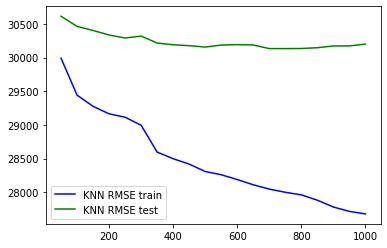

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

rmse_train_knn = []
rmse_test_knn = []

ks = range(50,1001,50)

for k in ks:

    reg = GradientBoostingRegressor(n_estimators=k, random_state=rs)
    reg.fit(X_train,y_train)
    y_pred = reg.predict(X_test)
    rmse_train_knn.append(mean_squared_error(y_train,reg.predict(X_train), squared = False))
    rmse_test_knn.append(mean_squared_error(y_test,y_pred, squared = False))
    print("k = ",k,"; RMSE Train = ",rmse_train_knn[len(rmse_train_knn)-1],"; RMSE Test = ",rmse_test_knn[len(rmse_test_knn)-1])

plt.plot(ks,rmse_train_knn, label = "KNN RMSE train", color = "blue")
plt.plot(ks,rmse_test_knn, label = "KNN RMSE test", color = "green")
plt.legend()

error, k = min(zip(rmse_test_knn,ks))
print("El menor error es", error, "y se alcanza con k =",k)

# XGBoost regressor

In [ ]:
!conda install -c conda-forge xgboost
!conda install -c anaconda py-xgboost

In [ ]:
import xgboost as xgb
regressor = xgb.XGBRegressor(
    n_estimators=100,
    reg_lambda=1,
    gamma=0,
    max_depth=3
)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)
rmse_lr_train = mean_squared_error(y_train,regressor.predict(X_train),squared = False)
rmse_lr_test = mean_squared_error(y_test,y_pred,squared = False)
print("Train RMSE:",rmse_lr_train)
print("Test RMSE:",rmse_lr_test)